In [9]:
# Import packages
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import cmaps
import xesmf as xe

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
import cartopy.feature as feature
from cartopy.util import add_cyclic_point
import cartopy.util as cutil

In [2]:
# File paths and file names
CESM_dir = "/scratch/racosta6/resolution-test/"
ERA5_dir = "/scratch/racosta6/resolution-test/ERA5/"
CESM3_name = "F.1850x0.25_C5_280_ihesp1046.01_ANN_concat.nc"
CESM1_name = "F.1850x2.0_C5_280_ihesp1046.01_ANN_concat.nc"
ERA5_name = "ERA5_tp_1979-2009_ANN_concat.nc"

# Load datasets
CESM3 = xr.open_dataset(CESM_dir + CESM3_name)
CESM1 = xr.open_dataset(CESM_dir + CESM1_name)
ERA5 = xr.open_dataset(ERA5_dir + ERA5_name)

In [3]:
ERA5.TP
CESM1

<xarray.Dataset>
Dimensions:        (time: 12, lat: 96, lon: 144, lev: 30, ilev: 31, slat: 95, slon: 144, nbnd: 2)
Coordinates:
  * ilev           (ilev) float64 2.255 5.032 10.16 18.56 ... 967.5 985.1 1e+03
  * lat            (lat) float64 -90.0 -88.11 -86.21 -84.32 ... 86.21 88.11 90.0
  * lev            (lev) float64 3.643 7.595 14.36 24.61 ... 957.5 976.3 992.6
  * lon            (lon) float64 0.0 2.5 5.0 7.5 ... 350.0 352.5 355.0 357.5
  * slat           (slat) float64 -89.05 -87.16 -85.26 ... 85.26 87.16 89.05
  * slon           (slon) float64 -1.25 1.25 3.75 6.25 ... 351.2 353.8 356.2
  * time           (time) object 0010-08-02 12:00:00 ... 0011-07-02 12:00:00
Dimensions without coordinates: nbnd
Data variables: (12/167)
    AEROD_v        (time, lat, lon) float32 ...
    ANRAIN         (time, lev, lat, lon) float32 ...
    ANSNOW         (time, lev, lat, lon) float32 ...
    AODDUST1       (time, lat, lon) float32 ...
    AODDUST3       (time, lat, lon) float32 ...
    AODVIS         (time, lat, lon) float32 ...
    ...             ...
    soa_a2_SRF     (time, lat, lon) float32 ...
    sol_tsi        (time) float64 ...
    time_bnds      (time, nbnd) object ...
    time_written   (time) |S8 ...
    w_stag         (slat) float64 ...
    wnummax        (lat) int32 ...
Attributes:
    Conventions:      CF-1.0
    source:           CAM
    case:             F.1850x2.0_C5_280_ihesp1046.01
    title:            UNSET
    logname:          pacosta
    host:             derecho3
    Version:          $Name$
    revision_Id:      $Id$
    initial_file:     /glade/derecho/scratch/pacosta/F.1850x2.0_C5_280_ihesp1...
    topography_file:  /glade/campaign/cesm/cesmdata/inputdata/atm/cam/topo/co...
    history:          Sun Jul  7 06:50:49 2024: ncrcat -O F.1850x2.0_C5_280_i...
    NCO:              netCDF Operators version 5.1.9 (Homepage = http://nco.s...

Type of data after adding cyclic point (plot 0): <class 'numpy.ma.core.MaskedArray'>


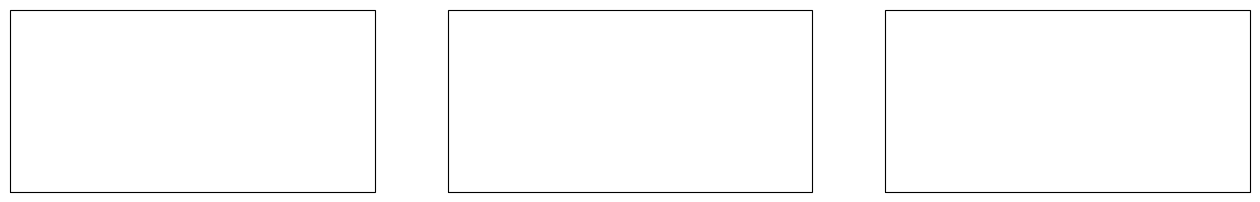

In [4]:
# DEBUG CODE

# Average the data and set it to a variable
CESM3_ann = CESM3.PRECC.mean(dim='time') + CESM3.PRECL.mean(dim='time')
ERA5_ann = ERA5.TP.mean(dim='time')

# Regrid
dstgrid = xr.Dataset({'lat': (['lat'], np.linspace(-90,90,181)),
                    'lon': (['lon'], np.linspace(0,359,360)),})

# --regridder -- 
regridder1 = xe.Regridder(CESM3_ann, dstgrid, 'bilinear', periodic= True)
regridder3 = xe.Regridder(ERA5_ann, dstgrid, 'bilinear', periodic= True)

# Do regridding
cesm_reg = regridder1(CESM3_ann)
era5_reg = regridder3(ERA5_ann)

# Calculate the anomaly
anom = cesm_reg - era5_reg

data = cesm_reg

# Add the cyclic point
data, lons = add_cyclic_point(data, coord=data['lon'])

# Debug: Check type after adding cyclic point
print(f"Type of data after adding cyclic point (plot {0}): {type(data)}")

# Adjust the levels so that the color gradient accurately represents the data
steps = np.arange(0, 17, 1)


# Define the figure and each axis for the 1 rows and 3 columns
fig, axs = plt.subplots(nrows=1, ncols=3,
                        subplot_kw={'projection': ccrs.PlateCarree()},
                        figsize=(16, 5.5))

# Contour plot
cs = axs[0].contourf(lons, cesm_reg.lat, data, levels=steps,
                    transform=ccrs.PlateCarree(),
                    cmap=cmaps.precip3_16lev, extend='both')

In [14]:
# Function to streamline plotting
def anom_panel_plot(cesm_ann, era5_ann, start_levels, end_levels, titles, cbar_title, allcmaps, path, save, extent=[-180, 180, -90, 90], lon_step=60, lat_step=30, step=0.5):
    # Regrid
    dstgrid = xr.Dataset({'lat': (['lat'], np.linspace(-90,90,181)),
                        'lon': (['lon'], np.linspace(0,359,360)),})

    # --regridder -- 
    regridder1 = xe.Regridder(cesm_ann, dstgrid, 'bilinear', periodic= True)
    regridder3 = xe.Regridder(era5_ann, dstgrid, 'bilinear', periodic= True)

    # Do regridding
    cesm_reg = regridder1(cesm_ann)
    era5_reg = regridder3(era5_ann)

    # Calculate the anomaly
    anom = cesm_reg - era5_reg

    ds_arr = [cesm_reg, anom, era5_reg]

    # Define the figure and each axis for the 1 rows and 3 columns
    fig, axs = plt.subplots(nrows=1, ncols=3,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(16, 5.5))

    # Loop over all of the datasets and plot
    for i in range(len(ds_arr)):

        # Select the dataset
        data = ds_arr[i]

        # Add the cyclic point
        data, lons = add_cyclic_point(data, coord=data['lon'])

        # Adjust the levels so that the color gradient accurately represents the data
        steps = np.arange(start_levels[i], end_levels[i], step)

        # Contour plot
        cs = axs[i].contourf(lons, ds_arr[i].lat, data, levels=steps,
                            transform=ccrs.PlateCarree(),
                            cmap=allcmaps[i], extend='both')

        # Title each subplot with the name of the model
        axs[i].set_title(titles[i])

        axs[i].set_extent(extent, crs=ccrs.PlateCarree())

        # Draw the coastines for each subplot
        axs[i].coastlines()

        # Define the xticks for longitude
        axs[i].set_xticks(np.arange(extent[0], extent[1] + 1, lon_step), crs=ccrs.PlateCarree())
        lon_formatter = cticker.LongitudeFormatter()
        axs[i].xaxis.set_major_formatter(lon_formatter)

        # Define the yticks for latitude
        axs[i].set_yticks(np.arange(extent[2], extent[3] + 1, lat_step), crs=ccrs.PlateCarree())
        lat_formatter = cticker.LatitudeFormatter()
        axs[i].yaxis.set_major_formatter(lat_formatter)

        # Add a colorbar and title it
        cbar = plt.colorbar(cs, ax=axs[i], orientation='horizontal')
        cbar.set_label(cbar_title)
        cbar.ax.xaxis.set_major_formatter(ticker.FuncFormatter(lambda x, _: int(x)))

    # Save the figure, or don't, show figure either way
    if save == True:
        plt.savefig(fname=path, format='pdf')
        plt.show()
    else:
        plt.show()

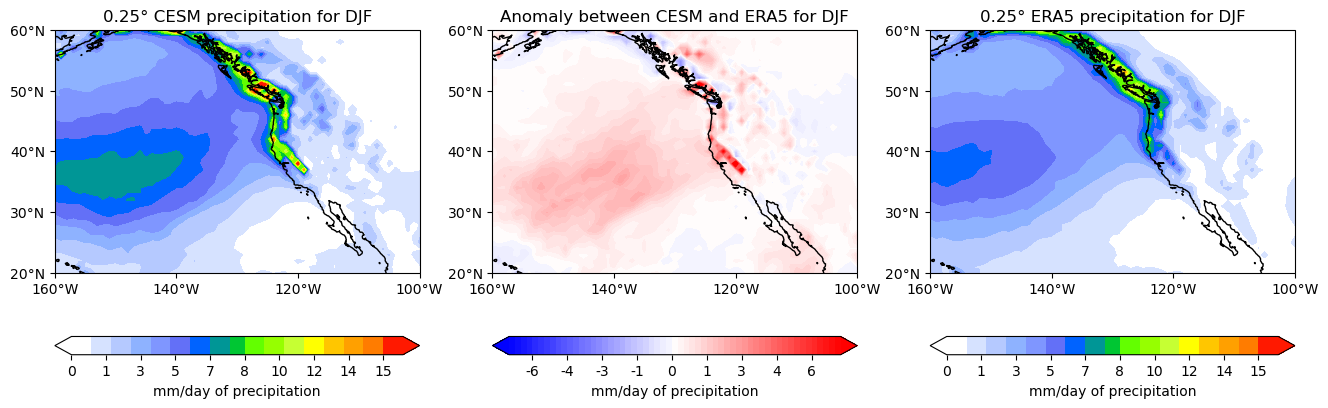

In [17]:
# Get DJF for CESM PRECC
CESM1_25 = CESM3.PRECC[0:2,:,:]
CESM1_2_25 = CESM3.PRECC[11,:,:]

# Get DJF for CESM PRECL
CESM2_25 = CESM3.PRECL[0:2,:,:]
CESM2_2_25 = CESM3.PRECL[11,:,:]

# Concat PRECC and PRECL independently to get DJF for each
CESM1_djf_25 = xr.concat([CESM1_25, CESM1_2_25], dim='time')
CESM2_djf_25 = xr.concat([CESM2_25, CESM2_2_25], dim='time')

# Add PRECC and PRECL to get total precipitation
CESM3_djf_25 = CESM1_djf_25 + CESM2_djf_25

# Average over DJF
CESM3_djf_25 = CESM3_djf_25.mean(dim='time')

# Get DJF for ERA5
ERA5_jf_25 = ERA5.TP[0:2,:,:]
ERA5_d_25 = ERA5.TP[11,:,:]

# Concat ERA5 jf and d to DJF
ERA5_djf_25 = xr.concat([ERA5_jf_25, ERA5_d_25], dim='time')

# Average over DJF
ERA5_djf_25 = ERA5_djf_25.mean(dim='time')

# Rename the longitude and latitude to lon and lat
ERA5_djf_25 = ERA5_djf_25.rename({'longitude': 'lon'})
ERA5_djf_25 = ERA5_djf_25.rename({'latitude': 'lat'})

# Unit conversions to mm/day
CESM3_djf_25 = CESM3_djf_25*1000*60*60*24
ERA5_djf_25 = ERA5_djf_25*1000

# Titles for looping through the plots
titles = ['0.25° CESM precipitation for DJF', 'Anomaly between CESM and ERA5 for DJF', '0.25° ERA5 precipitation for DJF']

# Color map for precipitation
precipcmap = cmaps.precip3_16lev

# Color bar title
cbar_title = 'mm/day of precipitation'

# Array to alternate between precip cmap and coolwarm
allcmaps = [precipcmap, cmaps.MPL_bwr, precipcmap]

# Levels for each of the plots, -7 to display negative values for the anomaly
start_levels = [0, -7, 0]
end_levels = [17, 7.5, 17]

# File save path
path = '/home/vreddy6/code/project/output_plots/ERA5_tp_anom_0.25_djf.pdf'

# Plot the data
anom_panel_plot(CESM3_djf_25, ERA5_djf_25, start_levels, end_levels, titles, cbar_title, allcmaps, path, True, [-160, -100, 20, 60], 20, 10, step=0.25)

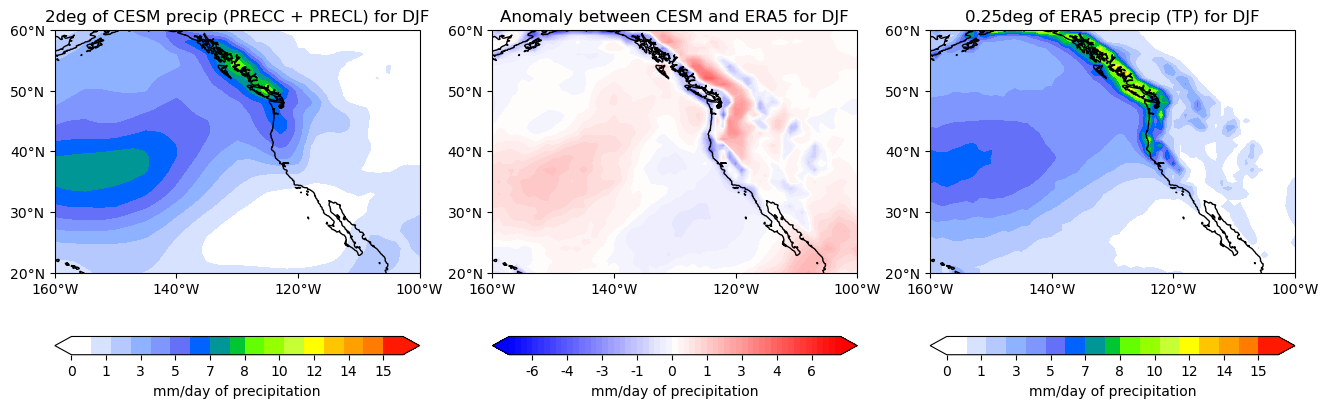

In [16]:
# Average the data and set it to a variable
# CESM1_ann = CESM1.PRECC.mean(dim='time') + CESM1.PRECL.mean(dim='time')
# ERA5_ann = ERA5.TP.mean(dim='time')

# Get DJF for CESM PRECC
CESM1_200 = CESM1.PRECC[0:2,:,:]
CESM1_2 = CESM1.PRECC[11,:,:]

# Get DJF for CESM PRECL
CESM2 = CESM1.PRECL[0:2,:,:]
CESM2_2 = CESM1.PRECL[11,:,:]

# Concat PRECC and PRECL independently to get DJF for each
CESM1_djf = xr.concat([CESM1_200, CESM1_2], dim='time')
CESM2_djf = xr.concat([CESM2, CESM2_2], dim='time')

# Add PRECC and PRECL to get total precipitation
CESM3_djf = CESM1_djf + CESM2_djf

# Average over DJF
CESM3_djf = CESM3_djf.mean(dim='time')

# Get DJF for ERA5
ERA5_jf = ERA5.TP[0:2,:,:]
ERA5_d = ERA5.TP[11,:,:]

# Concat ERA5 jf and d to DJF
ERA5_djf = xr.concat([ERA5_jf, ERA5_d], dim='time')

# Average over DJF
ERA5_djf = ERA5_djf.mean(dim='time')

ERA5_djf = ERA5_djf.rename({'longitude': 'lon'})
ERA5_djf = ERA5_djf.rename({'latitude': 'lat'})

CESM3_djf = CESM3_djf*1000*60*60*24
ERA5_djf = (ERA5_djf*1000)

# Titles for looping through the plots
titles = ['2° CESM precipitation for DJF', 'Anomaly between CESM and ERA5 for DJF', '0.25° ERA5 precipitation for DJF']

# Color map for precipitation
precipcmap = cmaps.precip3_16lev

# Color bar title
cbar_title = 'mm/day of precipitation'

# Array to alternate between precip cmap and coolwarm
allcmaps = [precipcmap, cmaps.MPL_bwr, precipcmap]

# Levels for each of the plots, -7 to display negative values for the anomaly
start_levels = [0, -7, 0]
end_levels = [17, 7.5, 17]

# File save path
path = '/home/vreddy6/code/project/output_plots/ERA5_tp_anom_2.0_djf.pdf'

# Plot the data
anom_panel_plot(CESM3_djf, ERA5_djf, start_levels, end_levels, titles, cbar_title, allcmaps, path, True, [-160, -100, 20, 60], 20, 10, step=0.25)